# Multi-layer Perceptron (MLP)

In [1]:
import os, sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from notebooks.utilities import plot_classification, plot_regression, plot_losses

## Forward Pass

For regression problems, we don't need an activation function.

$$
y\_pred = \text{Linear}(X \cdot w + b)
$$

For classification problems, we can apply either a sigmoid activation function or softmax.

$$
y\_pred = \text{Sigmoid}(X \cdot w + b)
$$

$$
y\_pred = \text{Softmax}(X \cdot w + b)
$$

where

$$
\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}} \\
\text{Softmax}(x) = \frac{e^{x}}{\sum_j e^{x_j}} \\
j \in \{ \text{num\_classes} \}
$$

In [2]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

## Loss Function

We need to use a loss function to measure how bad the model is doing given the current weights of the model.

For example, if we are predicting a regression problem, we could use mean squared error (MSE) as the loss function:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y\_pred - y\_true)^2
$$

## Gradient Computation

To be able to update the weights of the model, we need to compute the gradient of the loss function with respect to the weights.

We will use the chain rule from calculus to derive that.

$$
\begin{align}
\frac{\partial \text{MSE}}{\partial w} &= \frac{\partial \text{MSE}}{\partial y\_pred} \cdot \frac{\partial y\_pred}{\partial w} \\
&= \frac{1}{n} \sum_{i=1}^{n} 2(y\_pred - y\_true) \cdot \frac{\partial (X \cdot w + b)}{\partial w} \\
&= \frac{1}{n} \sum_{i=1}^{n} 2(y\_pred - y\_true) \cdot X \\

\frac{\partial \text{MSE}}{\partial b} &= \frac{\partial \text{MSE}}{\partial y\_pred} \cdot \frac{\partial y\_pred}{\partial b} \\
&= \frac{1}{n} \sum_{i=1}^{n} 2(y\_pred - y\_true) \cdot \frac{\partial (X \cdot w + b)}{\partial w} \\
&= \frac{1}{n} \sum_{i=1}^{n} 2(y\_pred - y\_true) \cdot 1 \\
\end{align}
$$

In [3]:
def mse_gradient_w(X, y_pred, y_true):
    """
    Compute the gradient of the mean squared error loss w.r.t. weights
    using the chain rule

    Args:
        X (num_samples, num_features)
        y_pred (num_samples)
        y_true (num_samples)

    Returns:
        (num_features): This dimension needs to align with the weights' dimension, which is num_features
    """
    return np.dot(X.T, 2 * (y_pred - y_true)) / len(y_true)


def mse_gradient_b(y_pred, y_true):
    """
    Compute the gradient of the mean squared error loss w.r.t. bias
    using the chain rule

    Returns:
        scalar
    """
    return 2 * np.mean(y_pred - y_true)

## Weight update

After we get the gradients for our loss function, we know how to update our weights.

$$
w_{t} = w_{t-1} - \alpha \cdot \frac{\partial \text{MSE}}{\partial w}
$$

where

$$
\alpha = \text{learning rate}
$$

## Combining everything together

This is a one-layer perceptron trying to predict scalar values for a given regression problem without any non-linearities.

In [4]:
def mlp(
    X,
    y,
    activation_fn=None,
    loss_fn=mse_loss,
    gradient_w=None,
    gradient_b=None,
    learning_rate=0.001,
    epochs=100,
):
    num_samples, num_features = X.shape
    w = np.zeros(num_features)
    b = 0

    plot_regression(y=y, y_pred=np.dot(X, w) + b, custom_title="before mlp")
    losses = []

    for epoch in range(epochs):
        y_pred = np.dot(X, w) + b
        y_pred = activation_fn(y_pred)
        loss = loss_fn(y_true=y, y_pred=y_pred)
        losses.append(loss)

        w -= learning_rate * gradient_w(X, y_pred, y)
        b -= learning_rate * gradient_b(y_pred, y)

        if epoch % (epochs // 10) == 0:
            print(f"[{epoch} EP] Loss: {loss}")

    return w, b, losses

(300, 5) (300,)


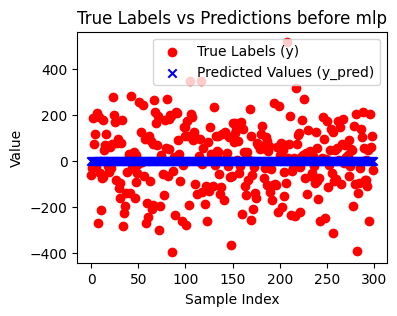

[0 EP] Loss: 20736.71204633509
[300 EP] Loss: 5961.162592178307
[600 EP] Loss: 1804.7182251150596
[900 EP] Loss: 608.0337362774862
[1200 EP] Loss: 253.74130263085837
[1500 EP] Loss: 145.40521430353508
[1800 EP] Loss: 111.0798180038838
[2100 EP] Loss: 99.79592886196352
[2400 EP] Loss: 95.95104956931924
[2700 EP] Loss: 94.59720587051797


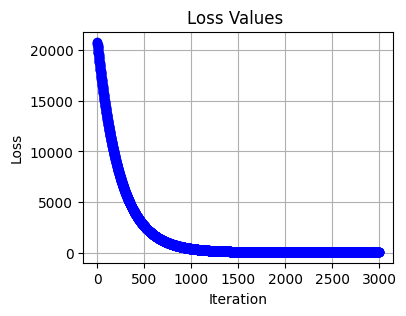

In [5]:
X, y = make_regression(n_samples=300, n_features=5, noise=10)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

w, b, losses = mlp(
    X,
    y,
    activation_fn=lambda d: d,
    loss_fn=mse_loss,
    gradient_w=mse_gradient_w,
    gradient_b=mse_gradient_b,
    learning_rate=0.001,
    epochs=3000,
)
plot_losses(losses)

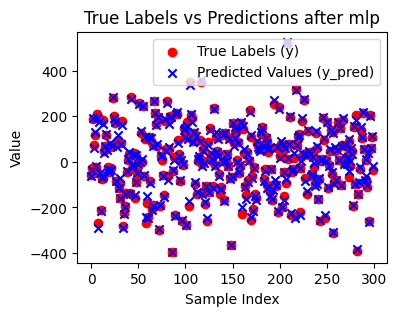

In [6]:
plot_regression(y=y, y_pred=np.dot(X, w) + b, custom_title="after mlp")

## Trying out classification problem

We need to define an activation function for this, we'll use the sigmoid function

$$
\text{activation}(x) = \sigma(x) = \frac{1}{1 + e^{-x}}
$$

Then we need to decide on the loss function for this. For classification problems, the binary crossentropy is a good candidate because it measures the difference between two distributions (y_true and y_pred)

$$
\text{BCE}(y\_true, y\_pred) = -\frac{1}{n} \sum_{i=1}^{n} y\_true \cdot \log(y\_pred) + (1 - y\_true) \cdot \log(1 - y\_pred)
$$

Then we will need to compute the gradient of the loss w.r.t. the weights and bias.

$$
\begin{align}
\frac{\partial \text{BCE}}{\partial w} &= \frac{\partial \text{BCE}}{\partial y\_pred} \cdot \frac{\partial y\_pred}{\partial \text{activation}(X \cdot w + b)} \cdot \frac{\partial \text{activation}(X \cdot w + b)}{\partial w} \\
\frac{\partial \text{BCE}}{\partial y\_pred} &= - \frac{y\_true}{y\_pred} - \frac{1 - y\_true}{1 - y\_pred} \\
\frac{\partial y\_pred}{\partial \text{activation}(X \cdot w + b)} &= y\_pred (1 - y\_pred)\\
\frac{\partial \text{activation}(X \cdot w + b)}{\partial w} &= X \\
\frac{\partial \text{BCE}}{\partial w} &= - \frac{y\_true}{y\_pred} - \frac{1 - y\_true}{1 - y\_pred} \cdot y\_pred (1 - y\_pred) \cdot X \tag{Combining 2,3,4} \\
&= \left( (1- y\_true) y\_pred - y\_true (1-y\_pred) \right) \cdot X \tag{Simplifying} \\
&= (y\_pred - y\_true) \cdot X \tag{Simplifying} \\
\frac{\partial \text{BCE}}{\partial b} &= \frac{1}{n} \sum_{i=1}^{n} (y\_pred - y\_true) \\
\end{align}
$$

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def bce_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


def bce_gradient_w(X, y_pred, y_true):
    return np.dot(X.T, (y_pred - y_true)) / X.shape[0]


def bce_gradient_b(y_pred, y_true):
    return np.mean(y_pred - y_true)

(100, 2) (100,)


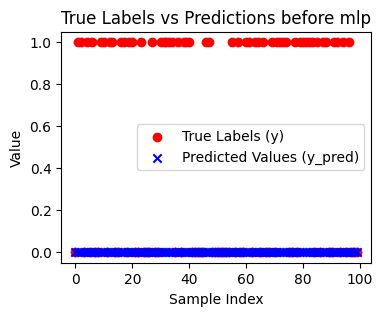

[0 EP] Loss: 0.6931471805599453
[300 EP] Loss: 0.5762070721206736
[600 EP] Loss: 0.49342983581187355
[900 EP] Loss: 0.433175162360903
[1200 EP] Loss: 0.3879162967889822
[1500 EP] Loss: 0.35290937497896935
[1800 EP] Loss: 0.3251267470709041
[2100 EP] Loss: 0.3025856130448575
[2400 EP] Loss: 0.28394940690004505
[2700 EP] Loss: 0.26829150670810514


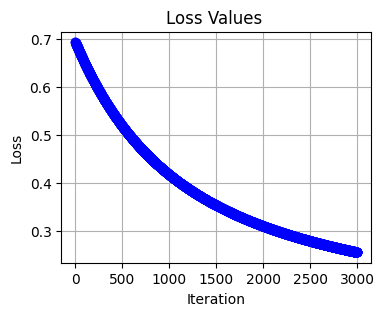

In [8]:
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_classes=2,
    n_clusters_per_class=1,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
)

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

w, b, losses = mlp(
    X,
    y,
    loss_fn=bce_loss,
    activation_fn=sigmoid,
    learning_rate=0.001,
    gradient_w=bce_gradient_w,
    gradient_b=bce_gradient_b,
    epochs=3000,
)

plot_losses(losses)

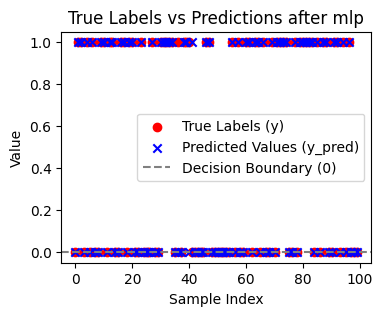

In [9]:
y_pred = (sigmoid(np.dot(X, w) + b) >= 0.5).astype(int)
plot_classification(y, y_pred=y_pred, custom_title="after mlp")